# Custom semantic segmentation model


In this notebook, we will desing, inspect and train a custome semantic segmentation model:

1. Select a semantic segmentation model: **UPerNet** [Unified Perceptual Parsing for Scene Understanding](https://arxiv.org/pdf/1807.10221.pdf)
2. Replabe the ResNet backbone with a new one: **ConvNeXt** [A ConvNet for the 2020s](https://arxiv.org/pdf/2201.03545.pdf)  
3. Config the heads.
4. Add a new dataset class.
5. Conduct training and evaluation.

<a href="https://colab.research.google.com/drive/1EX9uUhikpWkgO-E0Eews0mJaDPbQp6yl?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By [Ibrahim Sobh](https://www.linkedin.com/in/ibrahim-sobh-phd-8681757/)  

The new backbone: **ConvNeXt** [A ConvNet for the 2020s](https://arxiv.org/pdf/2201.03545.pdf)

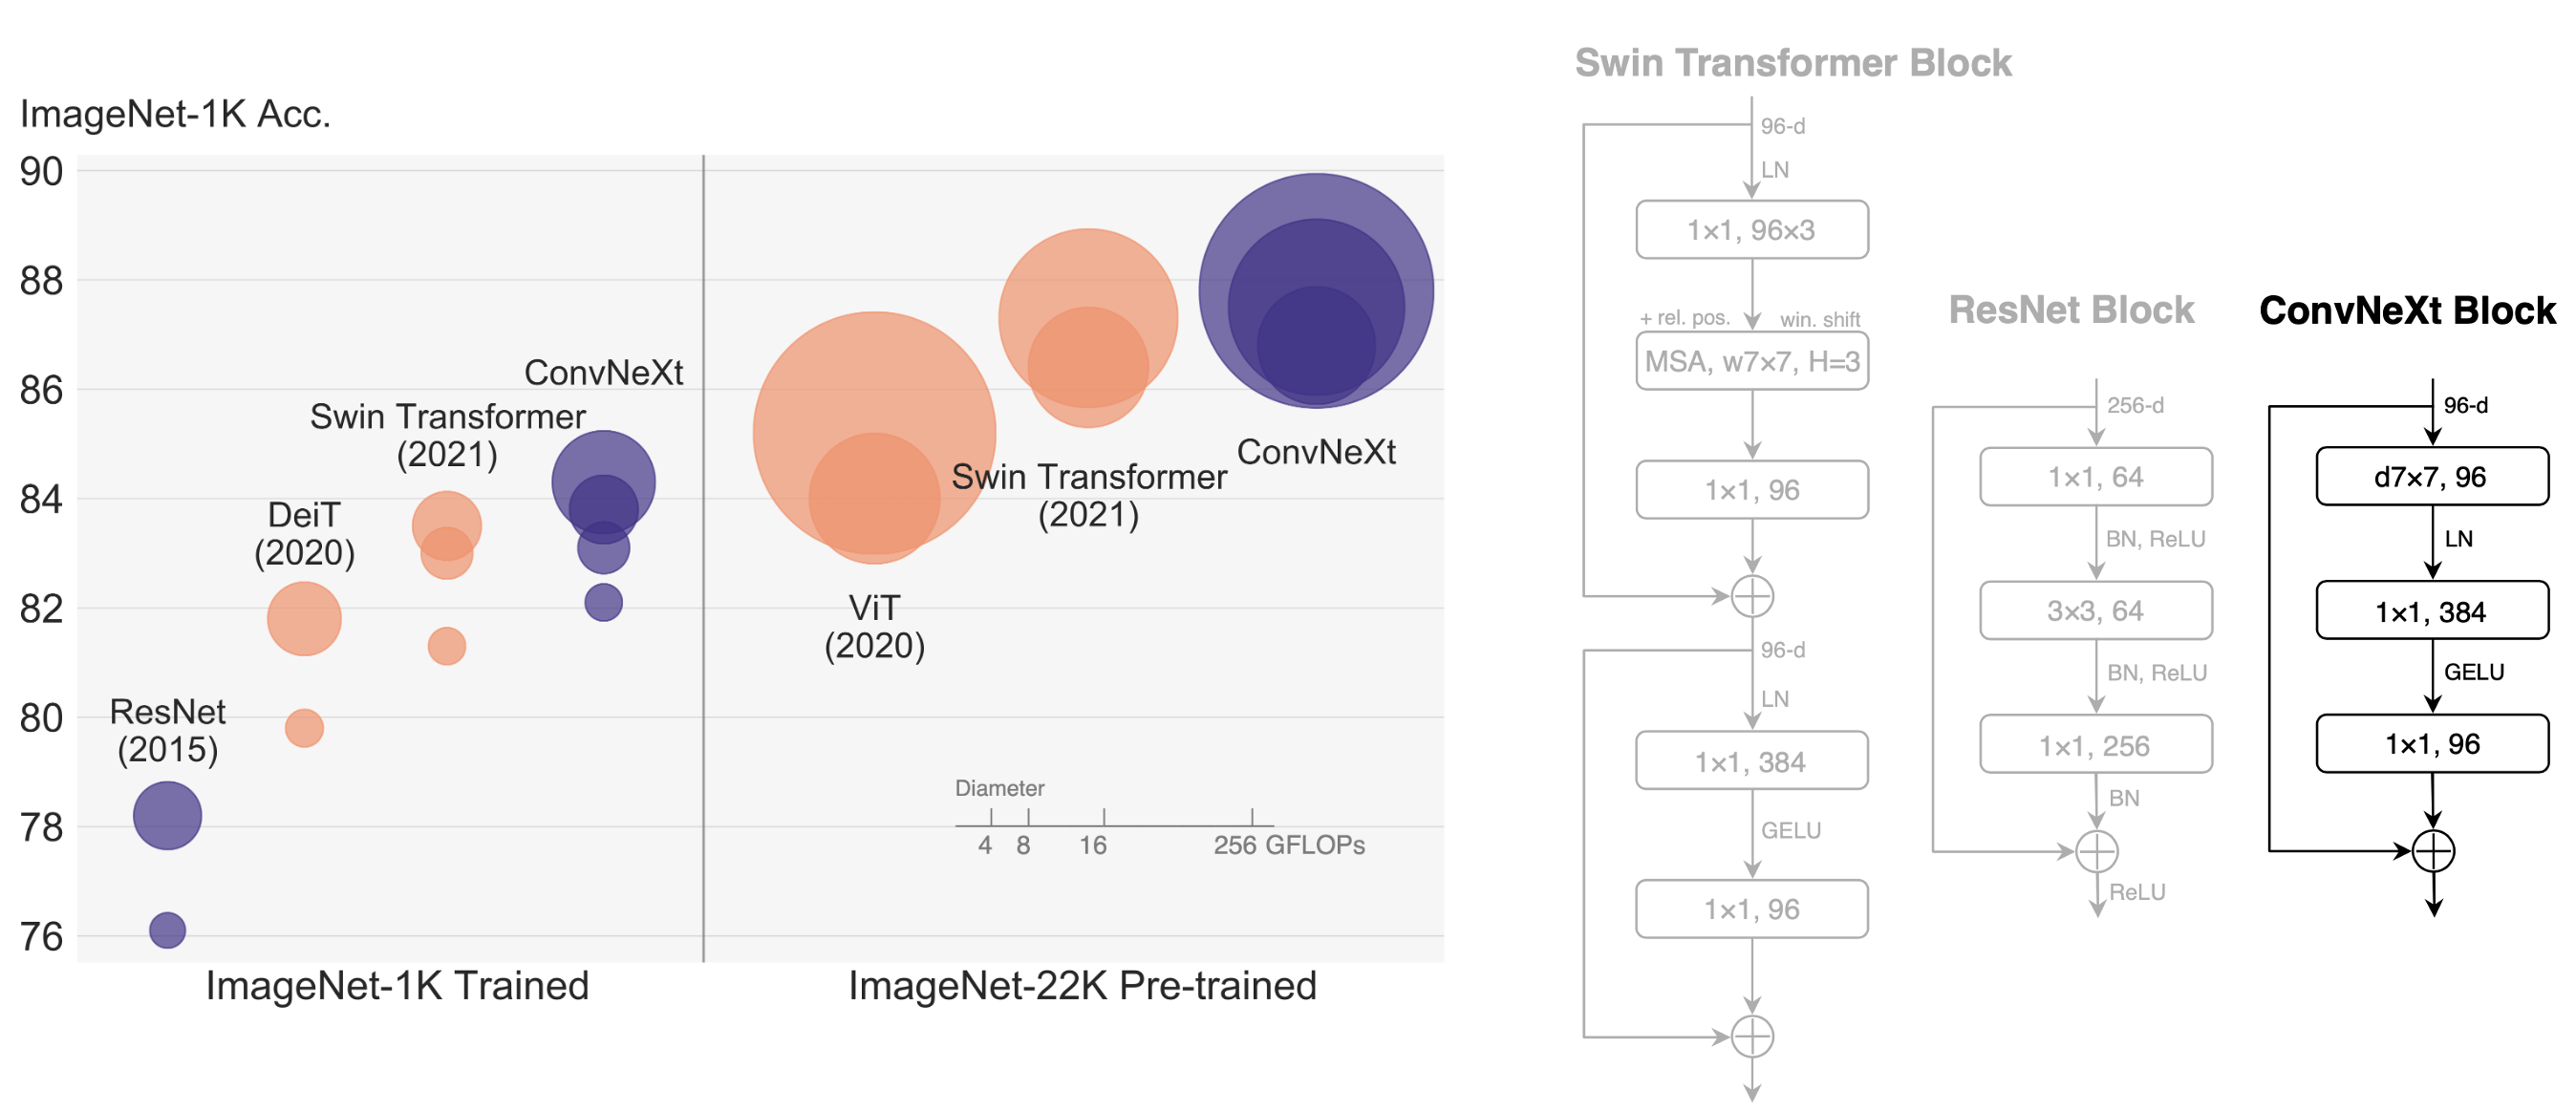

Scene Understanding Datasets
http://dags.stanford.edu/projects/scenedataset.html

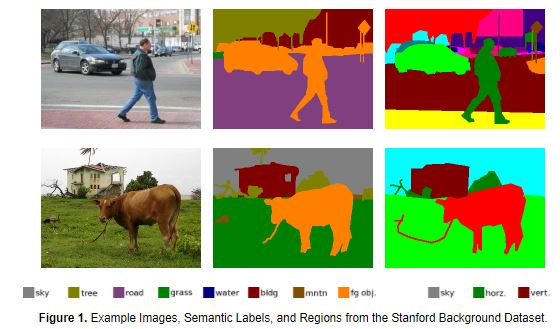

## Setup

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
import torch 
torch.__version__

'1.10.0+cu111'

In [3]:
!pip install openmim
!mim install mmsegmentation

  Created wheel for openmim: filename=openmim-0.1.5-py2.py3-none-any.whl size=42503 sha256=364465deebca7f41f6138365a3d1375cafd847c1a5ebf3120b49eab989863d10
  Stored in directory: /root/.cache/pip/wheels/16/8b/e1/bdebbbc687aa50224a5ce46fe97a040a0c59f92b34bfc750b6
Successfully built openmim
installing mmsegmentation from https://github.com/open-mmlab/mmsegmentation.git.
Cloning into '/tmp/tmpkrpl0p4v/mmsegmentation'...
remote: Enumerating objects: 6816, done.
remote: Total 6816 (delta 0), reused 0 (delta 0), pack-reused 6816
Receiving objects: 100% (6816/6816), 12.74 MiB | 23.75 MiB/s, done.
Resolving deltas: 100% (5062/5062), done.
Note: checking out '6670672345200cd6e855a2848d38cb56c9a15e82'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (

In [4]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git
%cd mmsegmentation

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 6816, done.
remote: Total 6816 (delta 0), reused 0 (delta 0), pack-reused 6816
Receiving objects: 100% (6816/6816), 12.73 MiB | 22.40 MiB/s, done.
Resolving deltas: 100% (5069/5069), done.
/content/mmsegmentation


## Start from a predefined model

### Download a predefined model

In [5]:
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmsegmentation/v0.5/upernet/upernet_r50_512x1024_40k_cityscapes/upernet_r50_512x1024_40k_cityscapes_20200605_094827-aa54cb54.pth \
      -O checkpoints/upernet_r50_512x1024_40k_cityscapes_20200605_094827-aa54cb54.pth

--2022-04-22 18:06:03--  https://download.openmmlab.com/mmsegmentation/v0.5/upernet/upernet_r50_512x1024_40k_cityscapes/upernet_r50_512x1024_40k_cityscapes_20200605_094827-aa54cb54.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 266000715 (254M) [application/octet-stream]
Saving to: ‘checkpoints/upernet_r50_512x1024_40k_cityscapes_20200605_094827-aa54cb54.pth’

checkpoints/upernet 100%[===================>] 253.68M  8.18MB/s    in 32s     

2022-04-22 18:06:37 (7.87 MB/s) - ‘checkpoints/upernet_r50_512x1024_40k_cityscapes_20200605_094827-aa54cb54.pth’ saved [266000715/266000715]



### Test inference

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
import mmcv
from google.colab.patches import cv2_imshow
import numpy as np 
import os.path as osp
from PIL import Image
import matplotlib.patches as mpatches

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:233: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: ./checkpoints/upernet_r50_512x1024_40k_cityscapes_20200605_094827-aa54cb54.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


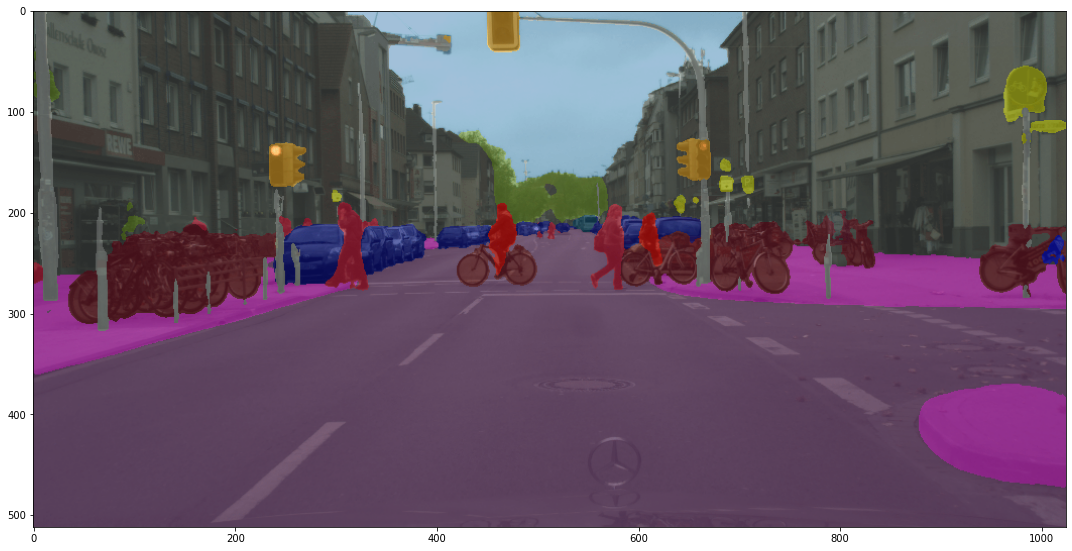

In [7]:
# Select a test image
img = 'demo/demo.png'
config_file = './configs/upernet/upernet_r50_512x1024_40k_cityscapes.py'
checkpoint_file = './checkpoints/upernet_r50_512x1024_40k_cityscapes_20200605_094827-aa54cb54.pth'
model = init_segmentor(config_file, checkpoint_file, device='cuda:0')
result = inference_segmentor(model, img)
show_result_pyplot(model, img, result, get_palette('cityscapes'))

## Download the custom dataset   

Based on [article](https://mducducd33.medium.com/sematic-segmentation-using-mmsegmentation-bcf58fb22e42)

In [8]:
# download and unzip
!wget http://dags.stanford.edu/data/iccv09Data.tar.gz -O stanford_background.tar.gz
!tar xf stanford_background.tar.gz

--2022-04-22 18:06:52--  http://dags.stanford.edu/data/iccv09Data.tar.gz
Resolving dags.stanford.edu (dags.stanford.edu)... 171.64.68.10
Connecting to dags.stanford.edu (dags.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14727974 (14M) [application/x-gzip]
Saving to: ‘stanford_background.tar.gz’

stanford_background 100%[===================>]  14.04M  7.26MB/s    in 1.9s    

2022-04-22 18:06:54 (7.26 MB/s) - ‘stanford_background.tar.gz’ saved [14727974/14727974]



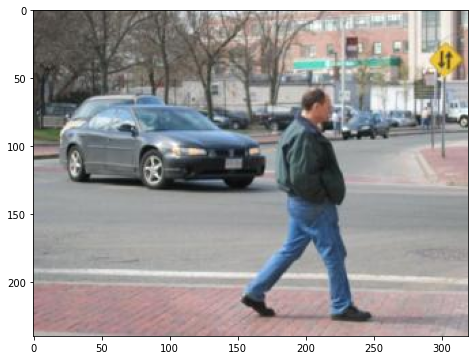

In [9]:
img = mmcv.imread('iccv09Data/images/6000124.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [10]:
# convert annotation (text labels) to semantic map (image)
data_root = 'iccv09Data'
img_dir = 'images'
ann_dir = 'labels'
classes = ('sky', 'tree', 'road', 'grass', 'water', 'bldg', 'mntn', 'fg obj')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34], 
           [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51]]
for file in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.regions.txt'):
  seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
  seg_img = Image.fromarray(seg_map).convert('P')
  seg_img.putpalette(np.array(palette, dtype=np.uint8))
  seg_img.save(osp.join(data_root, ann_dir, file.replace('.regions.txt', '.png')))

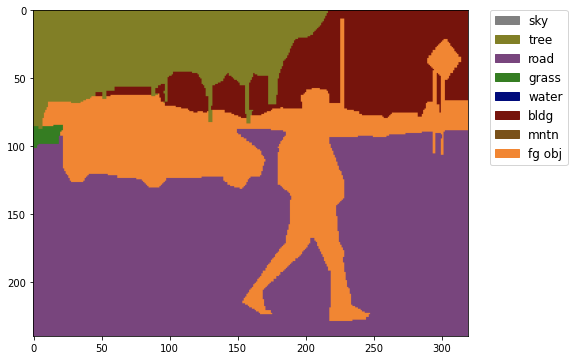

In [11]:
img = Image.open('iccv09Data/labels/6000124.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(8)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='large')

plt.show()

In [12]:
# split train/val set 
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 80% as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 20% as val set
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [13]:
@DATASETS.register_module()
class StanfordBackgroundDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

## Create the config file with the new backbone

> Indented block



In [173]:
# original file with ResNet backbone
print(config_file)

./configs/upernet/upernet_r50_512x1024_40k_cityscapes.py


In [174]:
from mmseg.apis import set_random_seed
from mmcv import Config
cfg = Config.fromfile(config_file)

### Design backbone

In [175]:
# original backbone
cfg.model.backbone

{'contract_dilation': True,
 'depth': 50,
 'dilations': (1, 1, 1, 1),
 'norm_cfg': {'requires_grad': True, 'type': 'SyncBN'},
 'norm_eval': False,
 'num_stages': 4,
 'out_indices': (0, 1, 2, 3),
 'strides': (1, 2, 2, 2),
 'style': 'pytorch',
 'type': 'ResNetV1c'}

In [176]:
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 1, 1),
        strides=(1, 2, 2, 2),
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='UPerHead',
        in_channels=[256, 512, 1024, 2048],
        in_index=[0, 1, 2, 3],
        pool_scales=(1, 2, 3, 6),
        channels=512,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,


In [177]:
cfg.model.pretrained=None
cfg.custom_imports = dict(imports='mmcls.models', allow_failed_imports=False)
cfg.checkpoint_file = 'https://download.openmmlab.com/mmclassification/v0/convnext/downstream/convnext-tiny_3rdparty_32xb128-noema_in1k_20220301-795e9634.pth'

In [178]:
# clear the defualt backbone and add a new one
# https://github.com/open-mmlab/mmsegmentation/blob/master/configs/convnext/upernet_convnext_tiny_fp16_512x512_160k_ade20k.py

cfg.model.backbone.clear() 
cfg.model.backbone.type='mmcls.ConvNeXt'
cfg.model.backbone.arch='tiny'
cfg.model.backbone.out_indices=[0, 1, 2, 3]
cfg.model.backbone.drop_path_rate=0.4
cfg.model.backbone.layer_scale_init_value=1.0
cfg.model.backbone.gap_before_final_norm=False
cfg.model.backbone.init_cfg=dict( type='Pretrained', checkpoint='https://download.openmmlab.com/mmclassification/v0/convnext/downstream/convnext-tiny_3rdparty_32xb128-noema_in1k_20220301-795e9634.pth', prefix='backbone.')

cfg.model.backbone

{'arch': 'tiny',
 'drop_path_rate': 0.4,
 'gap_before_final_norm': False,
 'init_cfg': {'checkpoint': 'https://download.openmmlab.com/mmclassification/v0/convnext/downstream/convnext-tiny_3rdparty_32xb128-noema_in1k_20220301-795e9634.pth',
  'prefix': 'backbone.',
  'type': 'Pretrained'},
 'layer_scale_init_value': 1.0,
 'out_indices': [0, 1, 2, 3],
 'type': 'mmcls.ConvNeXt'}

### Design heads

In [179]:
# adjust the decode_head
# https://github.com/open-mmlab/mmsegmentation/blob/master/configs/convnext/upernet_convnext_tiny_fp16_512x512_160k_ade20k.py
cfg.model.decode_head.type='UPerHead'
cfg.model.decode_head.in_channels=[96, 192, 384, 768]
cfg.model.decode_head.in_index=[0, 1, 2, 3]
cfg.model.decode_head.pool_scales=(1, 2, 3, 6)
cfg.model.decode_head.channels=512
cfg.model.decode_head.dropout_ratio=0.1
cfg.model.decode_head.num_classes=8  # num_classes
cfg.model.decode_head.norm_cfg=dict(type='BN', requires_grad=True)
cfg.model.decode_head.align_corners=False
cfg.model.decode_head.loss_decode=dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)
cfg.model.decode_head

{'align_corners': False,
 'channels': 512,
 'dropout_ratio': 0.1,
 'in_channels': [96, 192, 384, 768],
 'in_index': [0, 1, 2, 3],
 'loss_decode': {'loss_weight': 1.0,
  'type': 'CrossEntropyLoss',
  'use_sigmoid': False},
 'norm_cfg': {'requires_grad': True, 'type': 'BN'},
 'num_classes': 8,
 'pool_scales': (1, 2, 3, 6),
 'type': 'UPerHead'}

In [180]:
# adjust the auxiliary_head
# https://github.com/open-mmlab/mmsegmentation/blob/master/configs/convnext/upernet_convnext_tiny_fp16_512x512_160k_ade20k.py
cfg.model.auxiliary_head.type='FCNHead'
cfg.model.auxiliary_head.in_channels=384
cfg.model.auxiliary_head.in_index=2
cfg.model.auxiliary_head.channels=256
cfg.model.auxiliary_head.num_convs=1
cfg.model.auxiliary_head.concat_input=False
cfg.model.auxiliary_head.dropout_ratio=0.1
cfg.model.auxiliary_head.num_classes=8   # num_classes
cfg.model.auxiliary_head.norm_cfg=dict(type='BN', requires_grad=True)
cfg.model.auxiliary_head.align_corners=False
cfg.model.auxiliary_head.loss_decode=dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=0.4)
cfg.model.auxiliary_head

{'align_corners': False,
 'channels': 256,
 'concat_input': False,
 'dropout_ratio': 0.1,
 'in_channels': 384,
 'in_index': 2,
 'loss_decode': {'loss_weight': 0.4,
  'type': 'CrossEntropyLoss',
  'use_sigmoid': False},
 'norm_cfg': {'requires_grad': True, 'type': 'BN'},
 'num_classes': 8,
 'num_convs': 1,
 'type': 'FCNHead'}

In [181]:
# Use BN  instead of SyncBN (use only one GPU)
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

### Modify dataset type and path

In [182]:
cfg.dataset_type = 'StanfordBackgroundDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 4
cfg.data.workers_per_gpu= 4

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

In [183]:
# optimizer
cfg.optimizer.clear()
cfg.optimizer.constructor='LearningRateDecayOptimizerConstructor'
cfg.optimizer.type='AdamW'
cfg.optimizer.lr=0.0001
cfg.optimizer.betas=(0.9, 0.999)
cfg.optimizer.weight_decay=0.05
cfg.optimizeraramwise_cfg={
        'decay_rate': 0.9,
        'decay_type': 'stage_wise',
        'num_layers': 6}

# lr
cfg.lr_config.clear() 
cfg.lr_config.policy='poly'
cfg.lr_config.warmup='linear'
cfg.lr_config.warmup_iters=1500
cfg.lr_config.warmup_ratio=1e-6
cfg.lr_config.power=1.0
cfg.lr_config.min_lr=0.0
cfg.lr_config.by_epoch=False

In [184]:
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='mmcls.ConvNeXt',
        arch='tiny',
        out_indices=[0, 1, 2, 3],
        drop_path_rate=0.4,
        layer_scale_init_value=1.0,
        gap_before_final_norm=False,
        init_cfg=dict(
            type='Pretrained',
            checkpoint=
            'https://download.openmmlab.com/mmclassification/v0/convnext/downstream/convnext-tiny_3rdparty_32xb128-noema_in1k_20220301-795e9634.pth',
            prefix='backbone.'),
        norm_cfg=dict(type='BN', requires_grad=True)),
    decode_head=dict(
        type='UPerHead',
        in_channels=[96, 192, 384, 768],
        in_index=[0, 1, 2, 3],
        pool_scales=(1, 2, 3, 6),
        channels=512,
        dropout_ratio=0.1,
        num_classes=8,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntr

### Train the new custom model

In [185]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

datasets = [build_dataset(cfg.data.train)]
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

model.CLASSES = datasets[0].CLASSES

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

2022-04-22 19:18:24,603 - mmseg - INFO - Loaded 572 images
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:233: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
2022-04-22 19:18:25,428 - mmseg - INFO - Loaded 143 images
2022-04-22 19:18:25,430 - mmseg - INFO - Start running, host: root@0569

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 7.2 task/s, elapsed: 20s, ETA:     0s

2022-04-22 19:22:19,322 - mmseg - INFO - per class results:
2022-04-22 19:22:19,326 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 54.26 | 94.16 |
|  tree  | 26.76 |  40.0 |
|  road  |  62.4 | 68.39 |
| grass  | 48.21 | 66.65 |
| water  |  3.56 |  3.67 |
|  bldg  | 35.05 | 54.83 |
|  mntn  |  0.86 |  1.69 |
| fg obj | 24.69 | 38.74 |
+--------+-------+-------+
2022-04-22 19:22:19,329 - mmseg - INFO - Summary:
2022-04-22 19:22:19,330 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 56.7 | 31.97 | 46.02 |
+------+-------+-------+
2022-04-22 19:22:19,333 - mmseg - INFO - Iter(val) [143]	aAcc: 0.5670, mIoU: 0.3197, mAcc: 0.4602, IoU.sky: 0.5426, IoU.tree: 0.2676, IoU.road: 0.6240, IoU.grass: 0.4821, IoU.water: 0.0356, IoU.bldg: 0.3505, IoU.mntn: 0.0086, IoU.fg obj: 0.2469, Acc.sky: 0.9416, Acc.tree: 0.4000, Acc.road: 0.6839, Acc.grass: 0.6665, Acc.water: 0.0367, Acc.bldg: 0.5483, Ac

The model is trained after replacing the ResNet backbone with the ConvNext.   
We can see the loss is decreasing and accuaracy is increaisng as expected.    
Results can be enhanced using more epochs and optimizing lr, etc. 
